# Embeddings Exercise
## Preparation
- 1 Download Word2Vec embeddings from [link](https://github.com/frucci/pretrained-italian-word2vec-emb), both are in sqlite file format. Each embedding has 128 dimensions.
- 2 Get the [Haspeede 2020](https://ceur-ws.org/Vol-2765/paper162.pdf) dataset
- 3 Install pandas, sqlite3 and scikit-learn libraries.

## Exercise
Use word embeddings from point 1 to classify hate speech from dataset at point 2. The Haspedee dataset contains Twitter data labeled with "Hate" or "No-Hate".


In [1]:
# Insert here paths to embeddings files
itwac_path = 'data/30Marzo/embeddings/itwac128.sqlite'
twitter_path ='data/30Marzo/embeddings/twitter128.sqlite'

# Insert path to haspedee datasets here
haspedee_dataset_path = 'data/30Marzo/haspeede2020/haspeede2_dev_taskAB.tsv'

data_path = twitter_path

In [2]:
# Import and initializations
import pandas as pd
import sqlite3
import random
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

id_to_label = {"0":"NoHate", "1": "Hate"}
text_to_id_map = {}

def read_embedings(sqllite_path):
    """ Read sqlite embeddings from sqllite_path and returns them into a pandas DataFrame
    """
    con = sqlite3.connect(sqllite_path)
    df = pd.read_sql_query("SELECT * FROM store", con)
    con.close()
    return  df

def read_dataset(input_file):
  examples = []
  labels = []
  with open(input_file, 'r', encoding='utf-8', errors='ignore') as f:
      contents = f.read()
      file_as_list = contents.splitlines()
      random.shuffle(file_as_list)
      for line in file_as_list:
          if line.startswith("id"):
            continue
          split = line.split("\t")
          text = split[1]
          label = split[2]
          text_to_id_map[text] = split[0]
          labels.append(label)
          examples.append(text)
      f.close()
  return examples, labels


In [3]:
# Reading embeddings
# Each row contains a word and the corresponding embedding (128 dimensions) 
df = read_embedings(data_path)
df.set_index('key',inplace=True)
df.drop(columns={"ranking"},inplace=True)

In [4]:
# x contains the textual dataset
# y_ref contains the reference label i.e., 0 for no-hate and 1 for hate-
x, y_ref = read_dataset(haspedee_dataset_path)
number_of_0 = [value for value in y_ref if value == '0']
number_of_1 = [value for value in y_ref if value != '0']
print(f"check sbilanciamento dataset \n\n NoHate: {len(number_of_0)}\n Hate:{len(number_of_1)}")


check sbilanciamento dataset 

 NoHate: 4073
 Hate:2766


# Balancing Dataset

In [5]:
from random import sample

elements_to_remove = len(number_of_0) - len(number_of_1)

indexes_no_hate_elements = []
for i,elem in enumerate(y_ref):
    if elem == '0':
       indexes_no_hate_elements.append(i)
       
indexes_element_to_remove = sample(population=indexes_no_hate_elements,k=elements_to_remove)

x = [x for i,x in enumerate(x) if i not in indexes_element_to_remove]
y_ref = [y for i,y in enumerate(y_ref) if i not in indexes_element_to_remove]



In [6]:
number_of_0 = [value for value in y_ref if value == '0']
number_of_1 = [value for value in y_ref if value != '0']
print(f"check sbilanciamento etichette \n\n NoHate: {len(number_of_0)}\n Hate:{len(number_of_1)}")


check sbilanciamento etichette 

 NoHate: 2766
 Hate:2766


In [7]:
# *****PUT HERE YOUR CODE*****
from nltk.tokenize import word_tokenize
import nltk
import numpy as np
import re
import string 
punctuations = set(string.punctuation)
punctuations.add('\'')
punctuations.add('``')
punctuations.add('’')
punctuations.add('“')
punctuations.add('–')
punctuations.add('”')
punctuations.add('...')
punctuations.add('\'\'')


def from_word_to_embedding(word,embeddings):
    try:
        embedding = embeddings.loc[word]
    except:
        embedding = []
    
    return np.array(embedding)

 
def tokenize(phrase,language)-> list:
    if language == 'italian':
        return re.findall(r'\b[\w]+\b', phrase)
    else:
        return word_tokenize(phrase,language=language)

def normalize(tokens,language,puntuactions)-> list:

    normalized_tokens = [word.lower() for word in tokens]

    #remove puntuactions
    tokens_without_puntuactions = [w for w in normalized_tokens if w not in puntuactions]

    #remove stop words
    stopWords = nltk.corpus.stopwords.words(language)
    stopWords.append("user")
    stopWords.append("url")
    tokens_without_stop_words = [w for w in tokens_without_puntuactions if w not in stopWords]
    
    return tokens_without_stop_words

def from_phrase_to_embedding(phrase,df):

    embeddings =[]
    for word in phrase:
        single_word_embedding = from_word_to_embedding(word,df)
        
        if single_word_embedding.shape[0] >=1:
            embeddings.append(single_word_embedding)
    
    return np.mean(embeddings,axis=0)

embeddings =[]
for phrase in x:
    tokenized_phrase = tokenize(phrase=phrase,language="italian")

    normalized_phrase = normalize(tokens=tokenized_phrase,language="italian",puntuactions=punctuations)

    embeddings.append(from_phrase_to_embedding(normalized_phrase,df))

        
dataset = pd.DataFrame(columns=df.columns,data=embeddings)



In [8]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split, KFold

X_train, X_test, Y_train, Y_test = train_test_split(dataset,y_ref,test_size=0.30,random_state=454657)
model = LogisticRegressionCV(n_jobs=-1,cv=KFold(n_splits=10,random_state=23445547,shuffle=True),solver='liblinear')

model.fit(X_train,Y_train)

y_hyp = model.predict(X_test)


In [9]:
# Evaluate your results with these metrics
a = accuracy_score(Y_test,y_hyp)
p = precision_score(Y_test, y_hyp, pos_label="1")
r = recall_score(Y_test, y_hyp, pos_label="1")
f1 = f1_score(Y_test, y_hyp, pos_label="1")
print("precision: " + str(p) )
print("recall: " + str(r) )
print("accuracy: " + str(a) )
print("f1: " + str(f1) )

precision: 0.7067757009345794
recall: 0.7478368355995055
accuracy: 0.7259036144578314
f1: 0.7267267267267267


[[0.70505288 0.29494712]
 [0.25216316 0.74783684]]


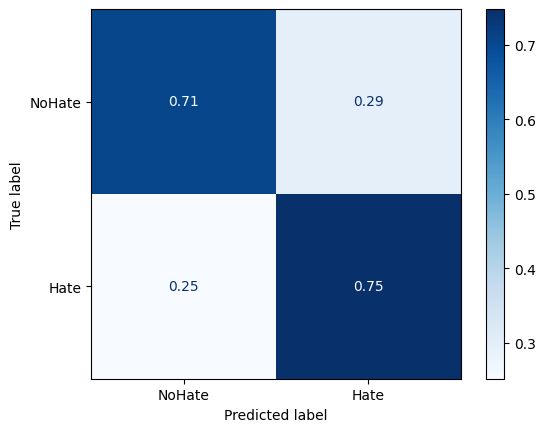

In [10]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt


disp = ConfusionMatrixDisplay.from_estimator(
        model,
        X_test,
        Y_test,
        display_labels=["NoHate","Hate"],
        cmap=plt.cm.Blues,
        normalize="true",
    )

print(disp.confusion_matrix)
plt.show()